# 🧠 Customer Segmentation & Sales Forecasting – Online Retail
# Author: Vedika Sankhe


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:
df = pd.read_csv("online_retail_II cleaned.csv")

In [4]:
print(df)

        Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041          RECORD FRAME 7" SINGLE SIZE        48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
793375   580501     23284        DOORMAT KEEP CALM AND COME IN         2   
793376   580501     22507         MEMO BOARD RETROSPOT  DESIGN         3   
793377   580502     22469                HEART OF WICKER SMALL         3   
793378   580502     23489                VINTAGE BELLS GARLAND         2   
793379   580502     23046    PAPER LANTERN 9 POINT DELUXE STAR         1   

             InvoiceDate  Price  Customer ID         Country  TotalAmount  
0       01-

In [5]:
print("Data Shape: ",df.shape)
print(df.head())

Data Shape:  (793380, 9)
   Invoice StockCode                          Description  Quantity  \
0   489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434    79323P                   PINK CHERRY LIGHTS        12   
2   489434    79323W                  WHITE CHERRY LIGHTS        12   
3   489434     22041          RECORD FRAME 7" SINGLE SIZE        48   
4   489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

        InvoiceDate  Price  Customer ID         Country  TotalAmount  
0  01-12-2009 07:45   6.95        13085  United Kingdom         83.4  
1  01-12-2009 07:45   6.75        13085  United Kingdom         81.0  
2  01-12-2009 07:45   6.75        13085  United Kingdom         81.0  
3  01-12-2009 07:45   2.10        13085  United Kingdom        100.8  
4  01-12-2009 07:45   1.25        13085  United Kingdom         30.0  


In [7]:
# Handle missing values
print("Missing Values:\n",df.isnull().sum())

Missing Values:
 Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64


In [9]:
# Convert date column to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],errors='coerce')

# Extract date features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day

# EXPLORATORY DATA ANALYSIS (EDA)


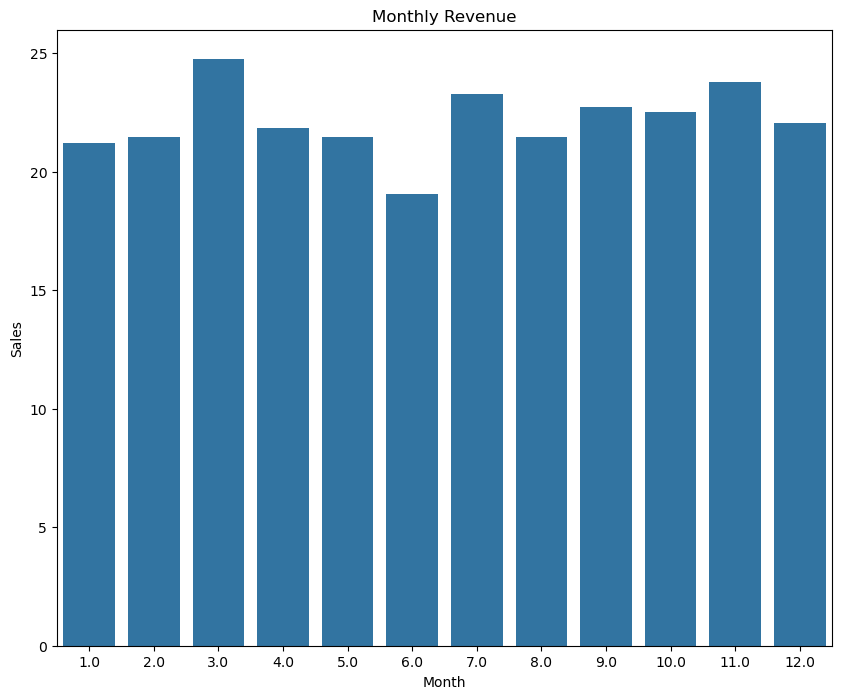

In [14]:
#Mothly Revenue
plt.figure(figsize=(10,8))
sns.barplot(data=df, x='Month', y='TotalAmount', errorbar=None)
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

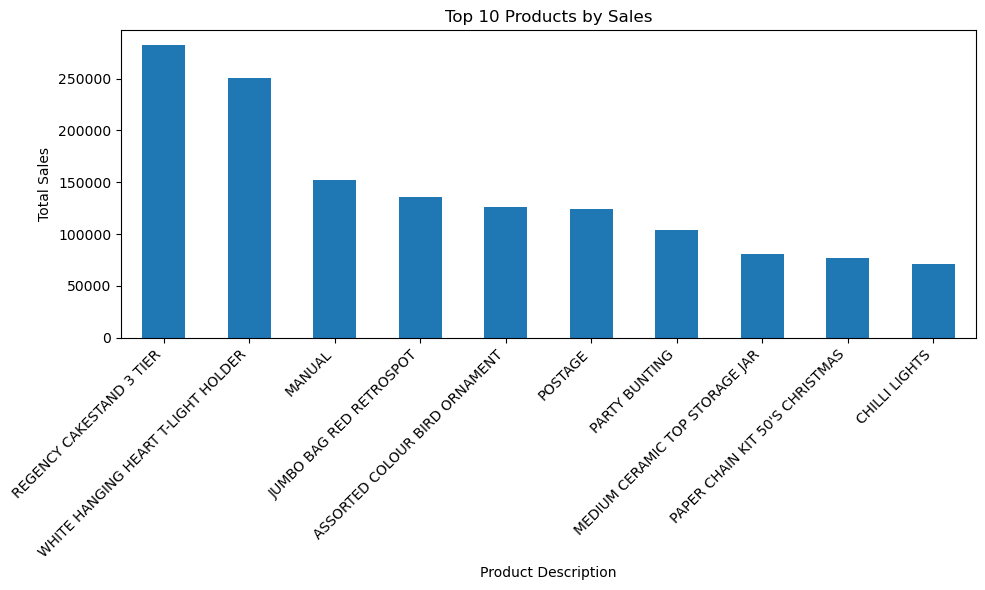

In [ ]:
#Plot top 10 products
top_products = df.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
top_products.plot(kind='bar')
plt.title("Top 10 Products by Sales")
plt.xlabel("Product Description")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

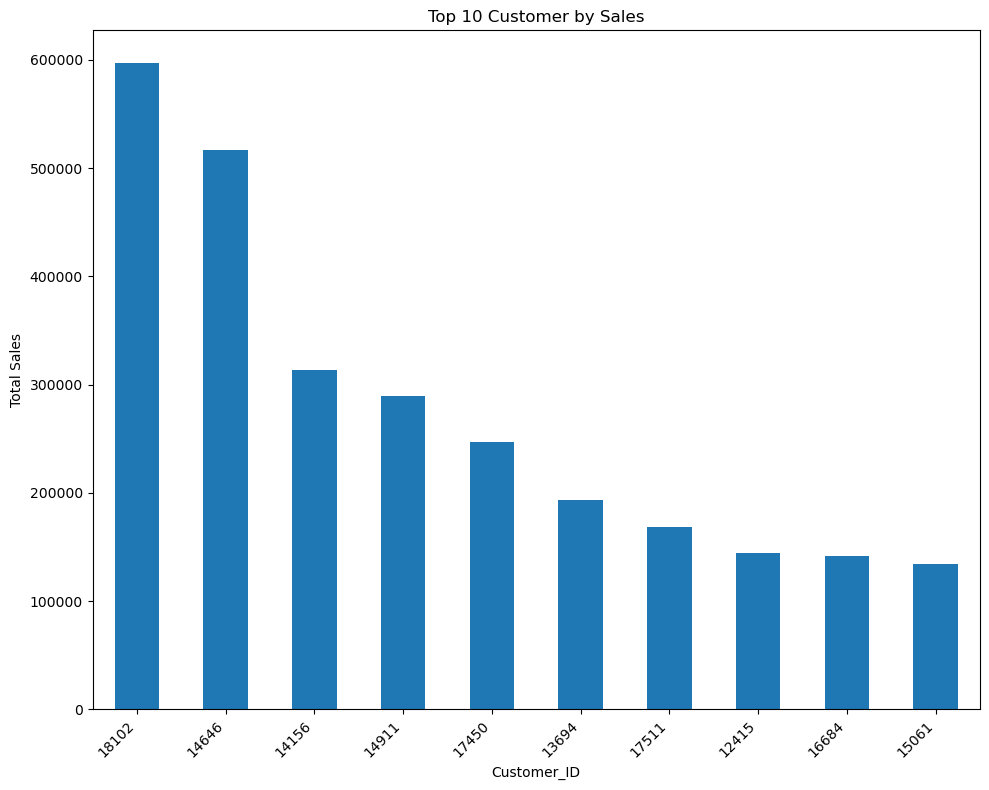

In [17]:
#Plot top 10 customers
top_customers = df.groupby('Customer ID')['TotalAmount'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,8))
top_customers.plot(kind='bar')
plt.xlabel("Customer_ID")
plt.ylabel("Total Sales")
plt.title("Top 10 Customer by Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

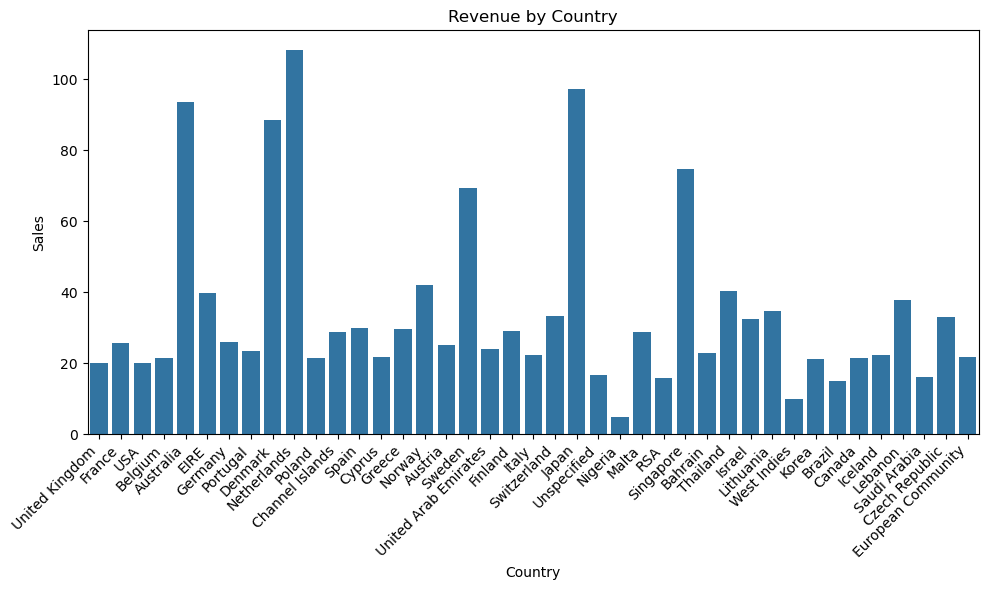

In [ ]:
#Country revenue distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Country', y='TotalAmount', errorbar=None)
plt.title("Revenue by Country")
plt.xlabel("Country")
plt.ylabel("Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

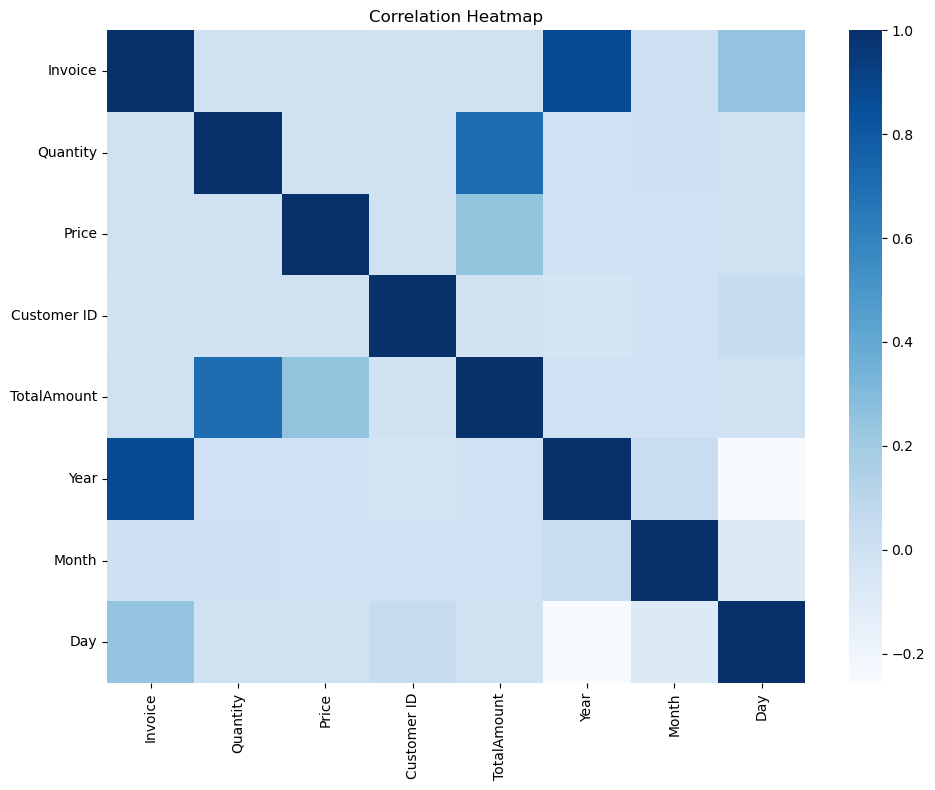

In [21]:
#Correlation Heatmap
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr,cmap="Blues",annot=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

## CUSTOMER SEGMENTATION (RFM + K-MEANS)


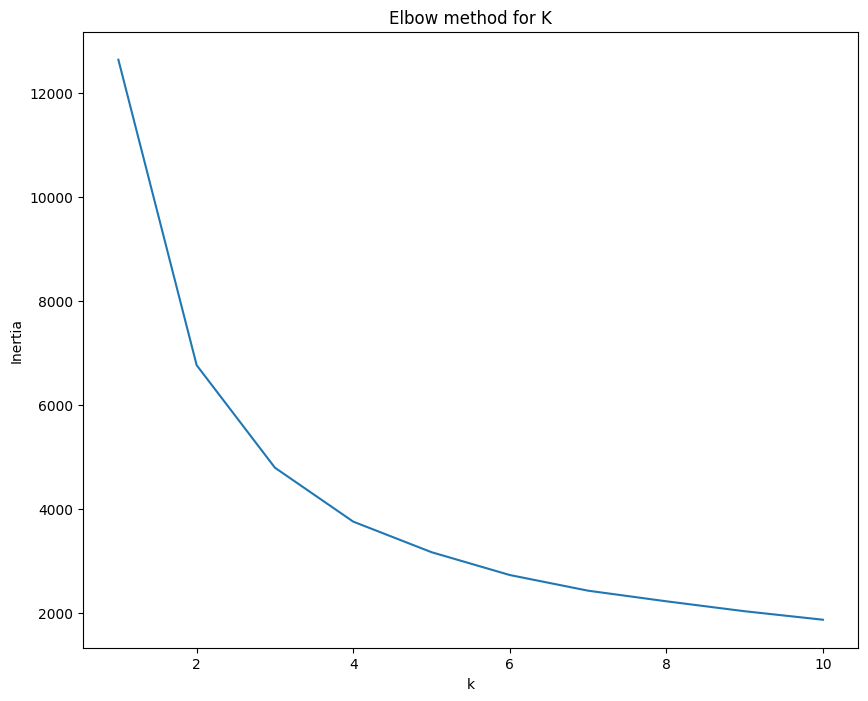

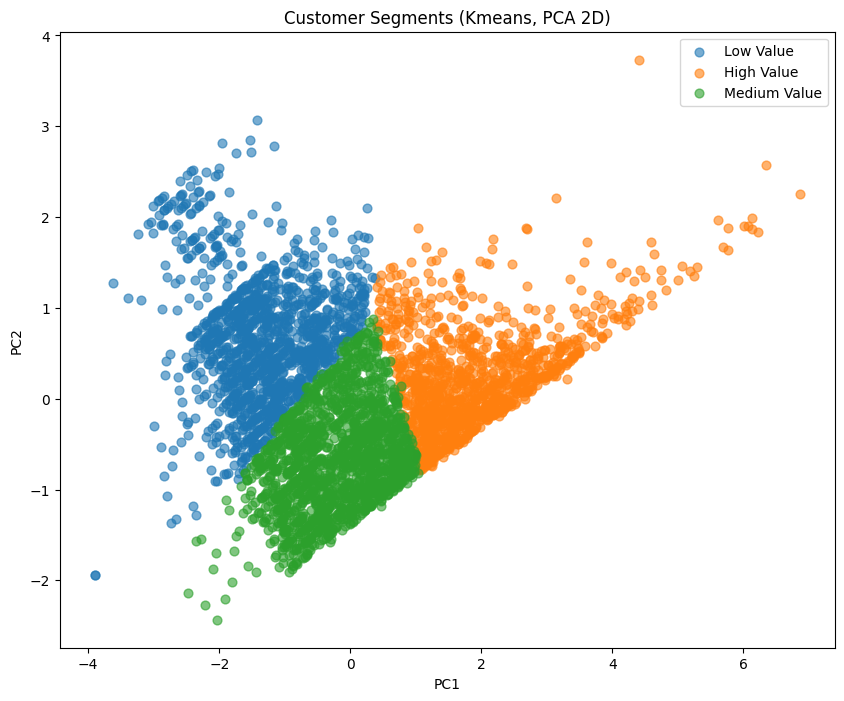

              Customer ID     Monetary  Frequency     Recency
Segment                                                      
High Value           1168  5613337.423   8.302226  115.357021
Low Value            1368   611459.420   1.390351  558.933480
Medium Value         1680   929468.251   1.837500  164.861310


In [ ]:
#Convert Columns in proper format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],errors='coerce')
#Ensure TotalAmount Column Exists
if 'TotalAmount' not in df.columns:
    df['TotalAmount'] = df['Quantity'] * df['Price']
#Droping rows with missing values
df = df.dropna(subset=['Customer ID','InvoiceDate','TotalAmount'])

#Build RFM
NOW = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'Invoice': 'nunique' if 'Invoice' in df.columns else('InvoiceNo' if 'InvoiceNo' in df.columns else 'count'),
    'TotalAmount': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'TotalAmount': 'Monetary',
})

if 'Invoice' in rfm.columns:
    rfm = rfm.rename(columns={'Invoice':'Frequency'})
elif 'InvoiceNo' in rfm.columns:
    rfm = rfm.rename(columns={'InvoiceNo':'Frequency'})
else:
    possible = [c for c in rfm.columns if c not in ['Recency','Monetary']]
    if possible:
        rfm = rfm.rename(columns={possible[0]:'Frequency'})
        
rfm = rfm.reset_index()

#Log Transform
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])    

#Scaling
features = ['Recency', 'Frequency_log', 'Monetary_log']
x = rfm[features].copy()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
#FIND BEST K (Elbow)
inertia=[]
k_range = range(1,11)
for k in k_range:
    km = KMeans(n_clusters=k,random_state=42,n_init=10)
    km.fit(x_scaled)
    inertia.append(km.inertia_)
    
plt.figure(figsize=(10,8))
plt.plot(k_range,inertia)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method for K')  
plt.show()

# KMeans Clustering 

k=3
kmeans = KMeans(n_clusters=k,random_state=42,n_init=50)
rfm['Cluster'] = kmeans.fit_predict(x_scaled)

#LABEL CLUSTERS (High/Medium/Low)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
centroids['Cluster'] = centroids.index
centroids['score'] = centroids['Monetary_log'] + centroids['Frequency_log'] - centroids['Recency'] * 0.01
centroids = centroids.sort_values('score',ascending=False)

centroids['Label'] = ['High Value','Medium Value', 'Low Value'][:len(centroids)]

#Map Label
label_map = centroids.set_index('Cluster')['Label'].to_dict()
rfm['Segment'] = rfm['Cluster'].map(label_map)

#VISUALIZE CLUSTERS (PCA 2D)
pca = PCA(n_components=2,random_state=42)
pca_coords = pca.fit_transform(x_scaled)
rfm['PC1'] = pca_coords[:,0]
rfm['PC2'] = pca_coords[:,1]

plt.figure(figsize=(10,8))
for seg in rfm['Segment'].unique():
    sub = rfm[rfm['Segment']== seg]
    plt.scatter(sub['PC1'],sub['PC2'],label=seg,alpha=0.6,s=40)
plt.title('Customer Segments (Kmeans, PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()   
 
#SHOW TOP CUSTOMERS BY SEGMENT
print(rfm.groupby('Segment').agg({
    'Customer ID': 'nunique' if 'Customer ID' in rfm.columns else 'count',
    'Monetary': 'sum',
    'Frequency': 'mean',
    'Recency': 'mean'
}))

## SALES FORECASTING

          ds         y
0 2009-01-01  44048.69
1 2009-02-01  52941.99
2 2009-03-01  67479.08
3 2009-04-01  34064.41
4 2009-05-01   9803.05


23:43:56 - cmdstanpy - INFO - Chain [1] start processing
23:43:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE on last 3 months: 0.4871, RMSE: 144973.91
Next 3 months forecast:
           ds           yhat     yhat_lower     yhat_upper
36 2012-01-01  369113.772578  267959.989764  475309.472100
37 2012-02-01  337647.714599  239250.307168  437204.223941
38 2012-03-01  479197.567337  377840.827666  583431.474171


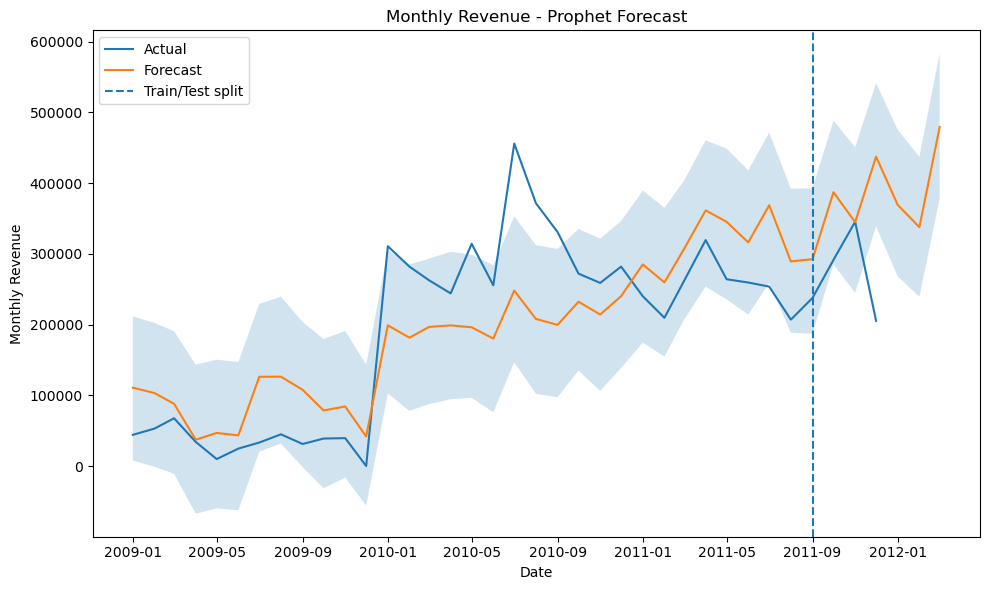

In [ ]:
df['TotalAmount'] = df.get('TotalAmount', df['Quantity'] * df['Price'])
df = df.dropna(subset=['InvoiceDate', 'TotalAmount'])

# monthly revenue
monthly = df.set_index('InvoiceDate').resample('MS')['TotalAmount'].sum().reset_index()  # 'MS' = month start
monthly = monthly.rename(columns={'InvoiceDate':'ds', 'TotalAmount':'y'})

# inspect
print(monthly.head())

n_test = 3
train = monthly[:-n_test]
test  = monthly[-n_test:]

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train)

future = m.make_future_dataframe(periods=n_test+3, freq='MS')  # extra 3 months for prediction horizon
forecast = m.predict(future)

pred = forecast[['ds','yhat']].set_index('ds').reindex(test['ds']).reset_index()
mape = mean_absolute_percentage_error(test['y'], pred['yhat'])
rmse = math.sqrt(mean_squared_error(test['y'], pred['yhat']))
print(f"MAPE on last {n_test} months: {mape:.4f}, RMSE: {rmse:.2f}")

# PREDICT NEXT 3 MONTHS 
future_pred = forecast[forecast['ds'] > monthly['ds'].max()].head(3)[['ds','yhat','yhat_lower','yhat_upper']]
print("Next 3 months forecast:")
print(future_pred)

# ---------- PLOT ----------
plt.figure(figsize=(10,6))
plt.plot(monthly['ds'], monthly['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
plt.axvline(train['ds'].max(), linestyle='--', label='Train/Test split')
plt.xlabel('Date')
plt.ylabel('Monthly Revenue')
plt.title('Monthly Revenue - Prophet Forecast')
plt.legend()
plt.tight_layout()
plt.show()

## SALES FORECASTING (SARIMAX)


c:\Users\Vedika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Vedika\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE: 0.2375, RMSE: 66990.81
Next 3 months forecast (SARIMAX):
2012-01-01    174150.446072
2012-02-01    188885.671393
2012-03-01    177664.007256
Freq: MS, Name: predicted_mean, dtype: float64


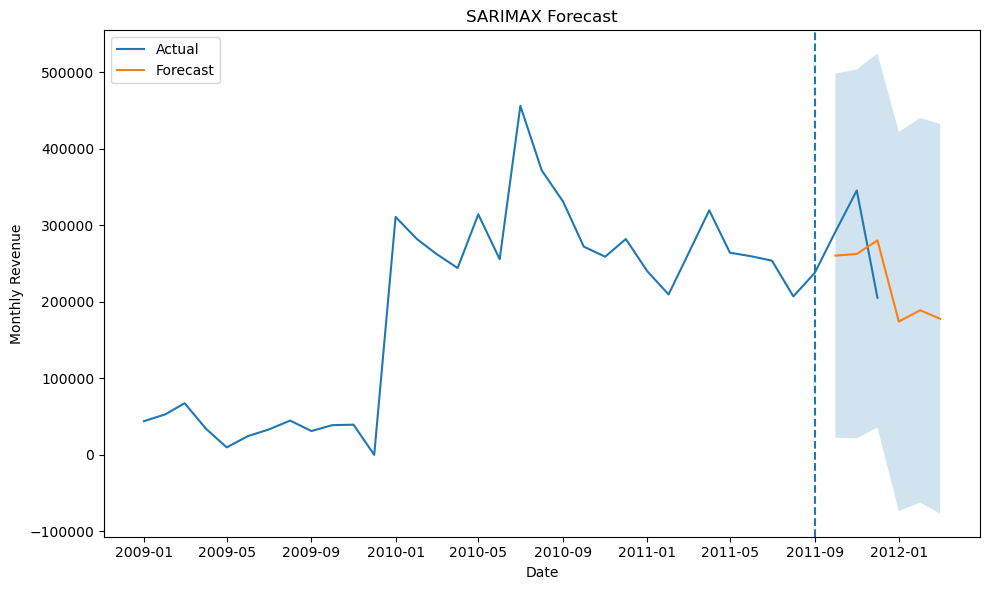

In [26]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['TotalAmount'] = df.get('TotalAmount', df['Quantity'] * df['Price'])
monthly = df.set_index('InvoiceDate').resample('MS')['TotalAmount'].sum()

# train/test
n_test = 3
train = monthly[:-n_test]
test = monthly[-n_test:]

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

# forecast
pred = res.get_forecast(steps=n_test+3)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# evaluation on test
pred_test = pred_mean[:n_test]
mape = mean_absolute_percentage_error(test.values, pred_test.values)
rmse = math.sqrt(mean_squared_error(test.values, pred_test.values))
print(f"MAPE: {mape:.4f}, RMSE: {rmse:.2f}")

# next 3 months
future_pred = pred_mean[n_test:n_test+3]
print("Next 3 months forecast (SARIMAX):")
print(future_pred)

# plot
plt.figure(figsize=(10,6))
plt.plot(monthly.index, monthly.values, label='Actual')
plt.plot(pred_mean.index, pred_mean.values, label='Forecast')
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], alpha=0.2)
plt.axvline(train.index.max(), linestyle='--')
plt.xlabel('Date')
plt.ylabel('Monthly Revenue')
plt.title('SARIMAX Forecast')
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
df.to_csv("Superb Retail Sales.csv")